<a href="https://colab.research.google.com/github/samvardhan777/Colipali/blob/main/Colipali_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "colpali-engine[train]"

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.9/31.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 s

In [27]:
!pip install pdf2image

In [2]:
import torch
import typer
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoProcessor
from PIL import Image
from typing import List, Tuple, Union

In [3]:
from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.utils.colpali_processing_utils import process_images, process_queries
from colpali_engine.utils.image_from_page_utils import load_from_dataset

In [4]:
from colpali_engine.trainer.retrieval_evaluator import CustomEvaluator

In [28]:
from pdf2image import convert_from_path

In [33]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 2s (122 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123597 

In [37]:
from IPython.display import display

In [38]:
import torch
from typing import List, Union
from PIL import Image

MOCK_IMAGE = Image.new("RGB", (448, 448), (255, 255, 255))


def load_model(model_name: str = "vidore/colpaligemma-3b-mix-448-base") -> Tuple[ColPali, AutoProcessor]:
    """Load ColPali model and processor.

    Args:
        model_name (str): The name or path of the pretrained model.

    Returns:
        Tuple[ColPali, AutoProcessor]: Loaded model and processor.
    """
    model = ColPali.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda").eval()
    processor = AutoProcessor.from_pretrained(model_name)
    return model, processor


def process_documents(documents: List[Union[str, Image.Image]], processor: AutoProcessor, model: ColPali) -> List[torch.Tensor]:
    """Process documents and get embeddings.

    Args:
        documents (List[Union[str, Image.Image]]): List of image paths or image objects.
        processor (AutoProcessor): Processor to preprocess the images.
        model (ColPali): The loaded ColPali model.

    Returns:
        List[torch.Tensor]: List of document embeddings.
    """
    dataloader = DataLoader(
        documents,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda x: process_images(processor, x)
    )
    document_embeddings = []
    for batch in tqdm(dataloader):
        with torch.no_grad():
            batch = {k: v.to(model.device) for k, v in batch.items()}
            embeddings = model(**batch)
        document_embeddings.extend(list(torch.unbind(embeddings.to("cpu"))))
    return document_embeddings


def process_queries_func(queries: List[str], processor: AutoProcessor, model: ColPali) -> List[torch.Tensor]:
    """Process queries and get embeddings.

    Args:
        queries (List[str]): List of text queries.
        processor (AutoProcessor): Processor to preprocess the text queries.
        model (ColPali): The loaded ColPali model.

    Returns:
        List[torch.Tensor]: List of query embeddings.
    """
    dataloader = DataLoader(
        queries,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda x: process_queries(processor, x, MOCK_IMAGE)
    )
    query_embeddings = []
    for batch in dataloader:
        with torch.no_grad():
            batch = {k: v.to(model.device) for k, v in batch.items()}
            embeddings = model(**batch)
        query_embeddings.extend(list(torch.unbind(embeddings.to("cpu"))))
    return query_embeddings


def evaluate_retrieval(query_embeddings: List[torch.Tensor], document_embeddings: List[torch.Tensor]) -> torch.Tensor:
    """Evaluate the retrieval using CustomEvaluator.

    Args:
        query_embeddings (List[torch.Tensor]): List of query embeddings.
        document_embeddings (List[torch.Tensor]): List of document embeddings.

    Returns:
        torch.Tensor: The similarity scores between queries and documents.
    """
    evaluator = CustomEvaluator(is_multi_vector=True)
    scores = evaluator.evaluate(query_embeddings, document_embeddings)
    return scores



def process_documents_with_filenames(
    documents_with_filenames: List[Tuple[Image.Image, str]],
    processor: AutoProcessor,
    model: ColPali
) -> Tuple[List[torch.Tensor], List[str]]:
    """Process documents and return embeddings along with filenames."""
    images = [doc[0] for doc in documents_with_filenames]  # Extract the image objects
    filenames = [doc[1] for doc in documents_with_filenames]  # Extract the filenames

    dataloader = DataLoader(
        images,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda x: process_images(processor, x)
    )
    document_embeddings = []
    for batch in tqdm(dataloader):
        with torch.no_grad():
            batch = {k: v.to(model.device) for k, v in batch.items()}
            embeddings = model(**batch)
        document_embeddings.extend(list(torch.unbind(embeddings.to("cpu"))))

    return document_embeddings, filenames



def convert_pdf_to_images(pdf_path: str) -> List[Image.Image]:
    """Convert a PDF into a list of images (one per page)."""
    try:
        images = convert_from_path(pdf_path)
        return images
    except Exception as e:
        print(f"Error converting PDF {pdf_path}: {e}")
        return []


def convert_pdf_to_images(pdf_path: str) -> List[Image.Image]:
    """Convert a PDF into a list of images (one per page)."""
    try:
        images = convert_from_path(pdf_path)
        return images
    except Exception as e:
        print(f"Error converting PDF {pdf_path}: {e}")
        return []

def load_images_with_filenames_from_pdfs(pdf_paths: List[str]) -> List[Tuple[Image.Image, str]]:
    """Convert PDFs to images and return them with filenames."""
    images_with_filenames = []
    for pdf_path in pdf_paths:
        images = convert_pdf_to_images(pdf_path)
        for i, image in enumerate(images):
            image_filename = f"{pdf_path} - Page {i+1}"  # Label each page with the PDF name and page number
            images_with_filenames.append((image, image_filename))
    return images_with_filenames

def search_documents(
    model,
    processor,
    documents_with_filenames: List[Tuple[Image.Image, str]],
    queries: List[str],
    top_k: int = 5
) -> None:
    """Search and retrieve documents based on queries, showing document names, pages, scores, and images."""

    # Step 1: Process and get embeddings for documents
    document_embeddings, filenames = process_documents_with_filenames(documents_with_filenames, processor, model)

    # Step 2: Process and get embeddings for queries
    query_embeddings = process_queries_func(queries, processor, model)

    # Step 3: Evaluate retrieval
    scores = evaluate_retrieval(query_embeddings, document_embeddings)

    # Step 4: Get top-k results and display document names, page numbers, scores, and images
    top_results = scores.argsort(axis=1)[:, -top_k:][:, ::-1]  # Sort and get top-k
    for i, query in enumerate(queries):
        print(f"\nQuery: {query}")
        print(f"Top {top_k} results:")
        for idx in top_results[i]:
            # Extract document name and page number from the filename
            document_name, page_info = filenames[idx].split(' - Page ')
            print(f"Document: {document_name}, Page: {page_info} - Score: {scores[i][idx]:.4f}")

            # Display the corresponding image
            image = documents_with_filenames[idx][0]  # Get the image from the tuple
            display(image)  # Use IPython.display to show the image

In [6]:
model, processor = load_model()

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [35]:
pdf_paths = ["/content/364253783.pdf"]

# Convert PDFs to images and get filenames (including page numbers)
documents_with_filenames = load_images_with_filenames_from_pdfs(pdf_paths)

# Queries


100%|██████████| 2/2 [00:16<00:00,  8.17s/it]

tensor([0, 0])
Top 1 Accuracy (verif): 0.5

Query: What is the total amount?
Top 3 results:
Document: /content/364253783.pdf - Page 6 - Score: 18.875
Document: /content/364253783.pdf - Page 5 - Score: 18.875
Document: /content/364253783.pdf - Page 4 - Score: 18.875

Query: Who is the recipient of the invoice?
Top 3 results:
Document: /content/364253783.pdf - Page 6 - Score: 20.75
Document: /content/364253783.pdf - Page 5 - Score: 20.75
Document: /content/364253783.pdf - Page 4 - Score: 20.75


100%|██████████| 2/2 [00:14<00:00,  7.42s/it]


tensor([0, 0])
Top 1 Accuracy (verif): 0.5

Query: Dr.S.Vijayalakshmi
Top 3 results:
Document: /content/364253783.pdf, Page: 6 - Score: 19.7500


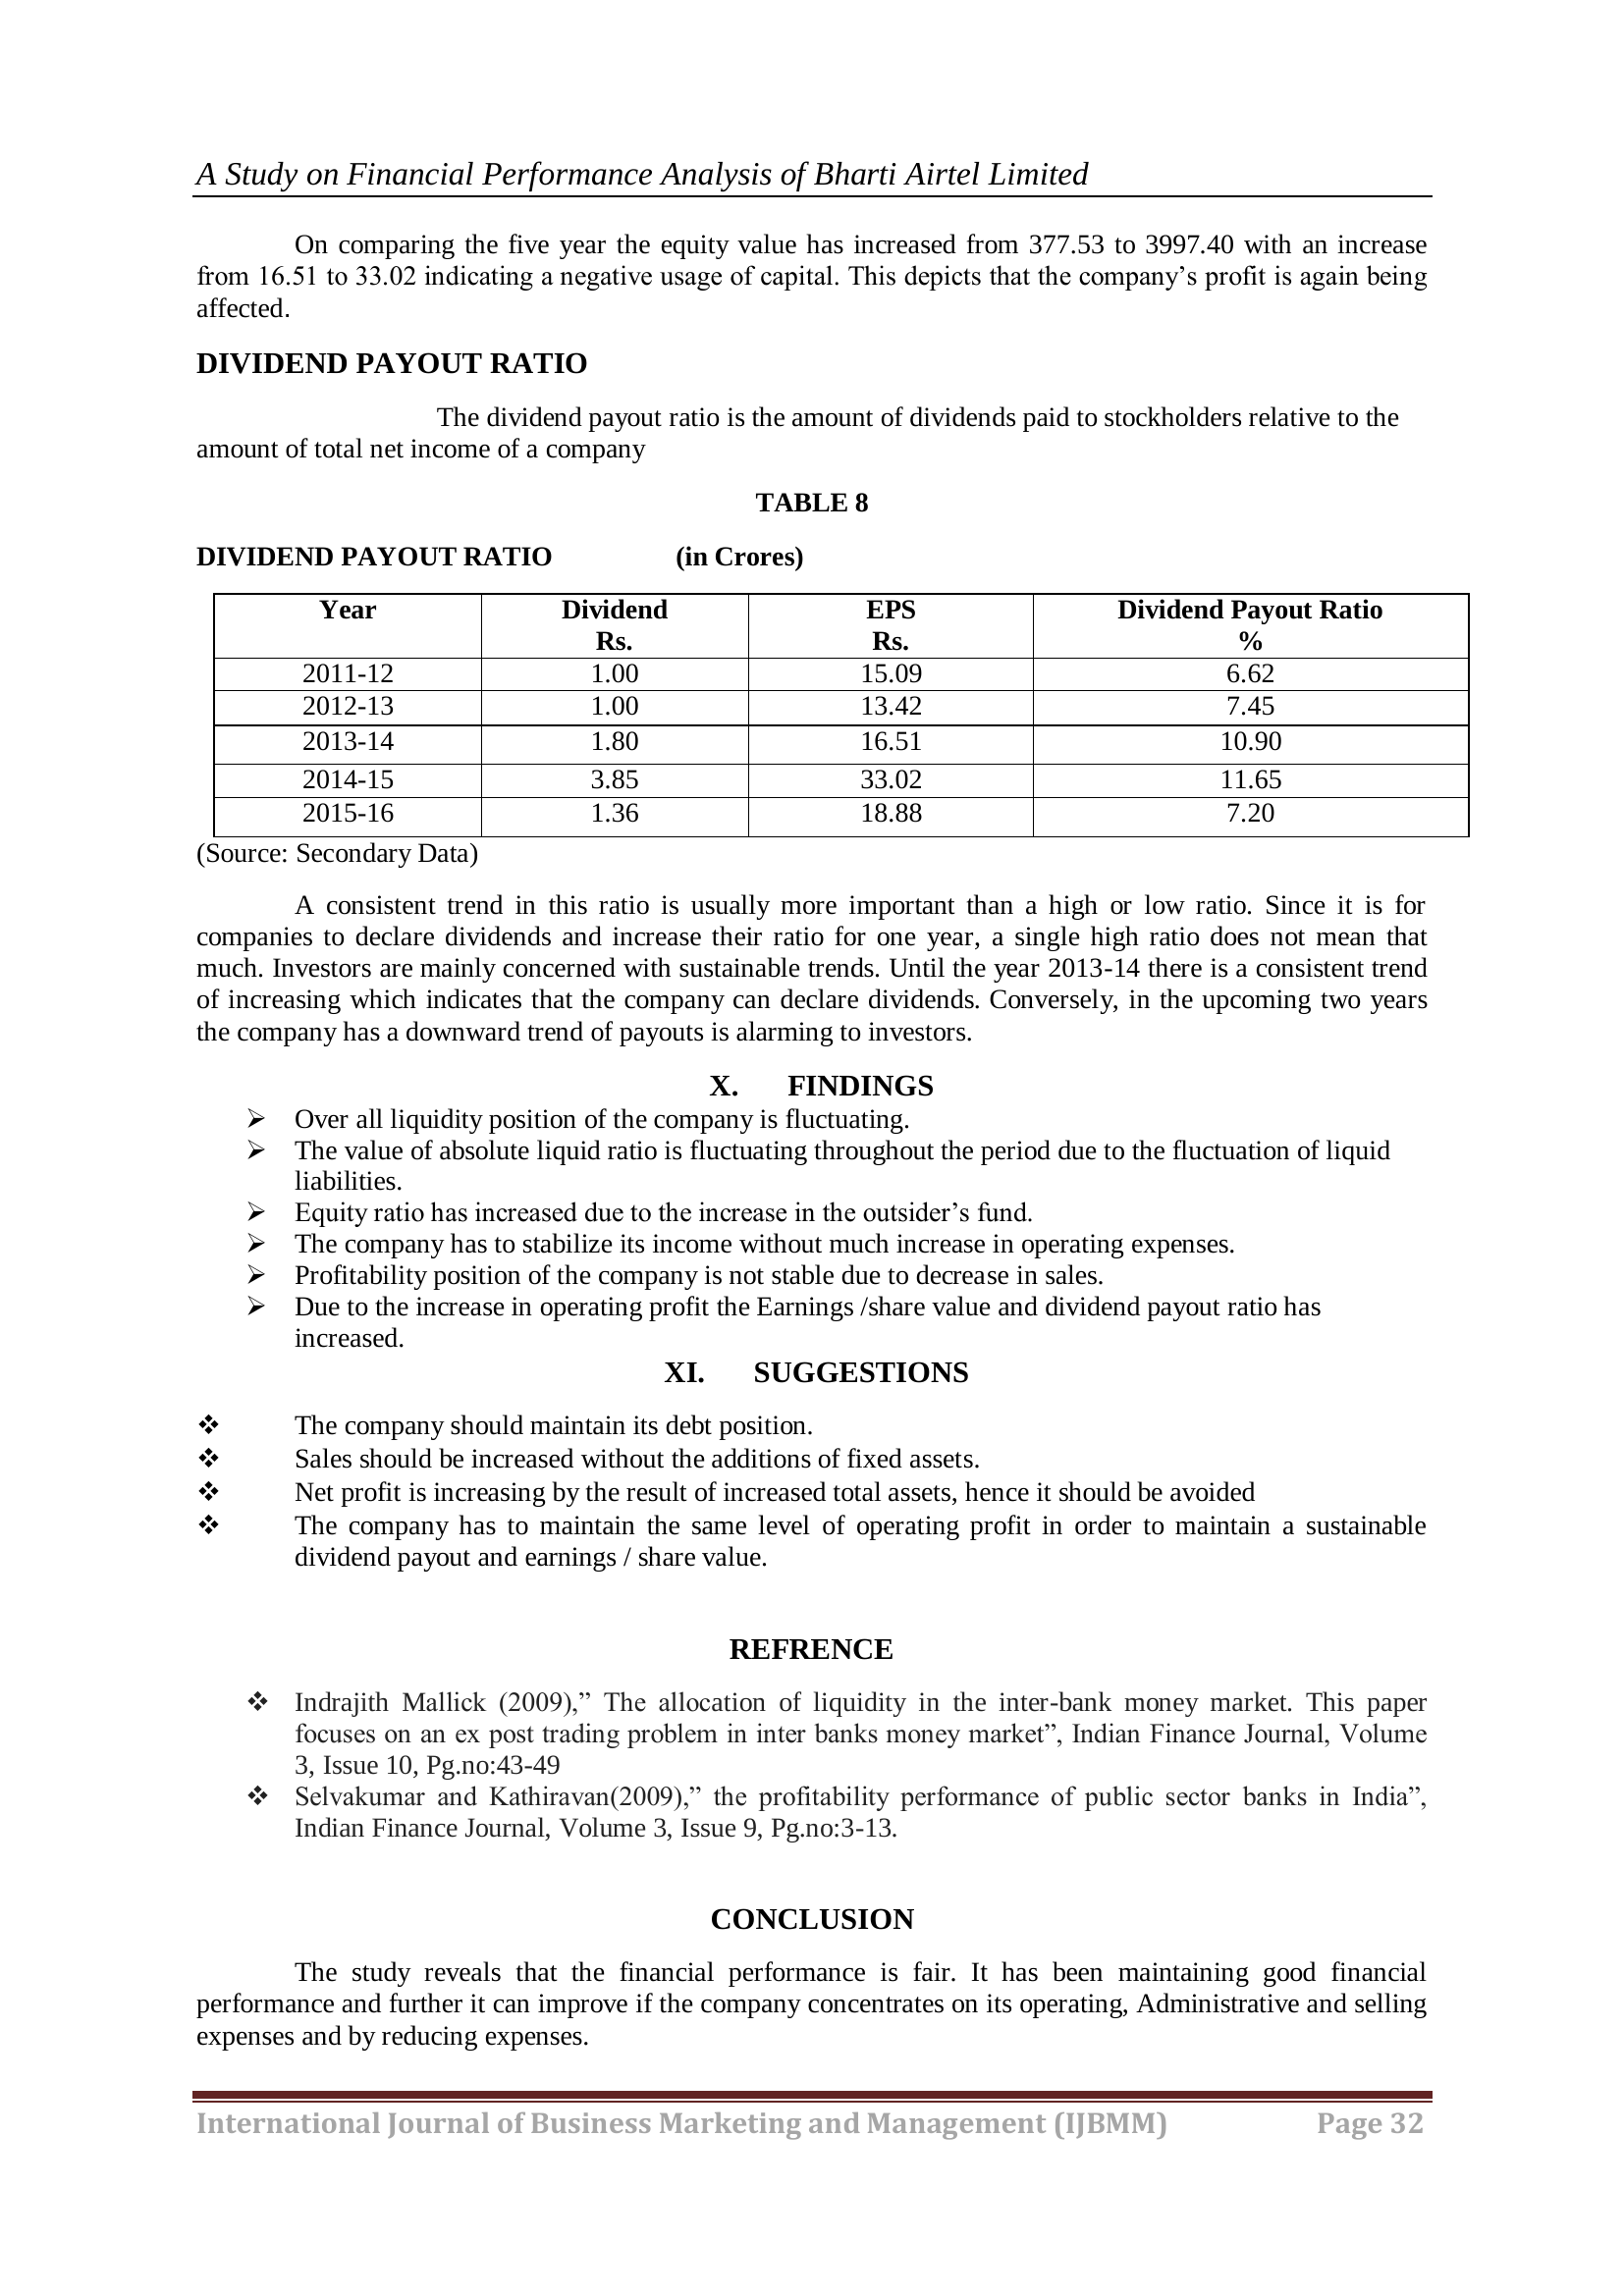

Document: /content/364253783.pdf, Page: 5 - Score: 19.7500


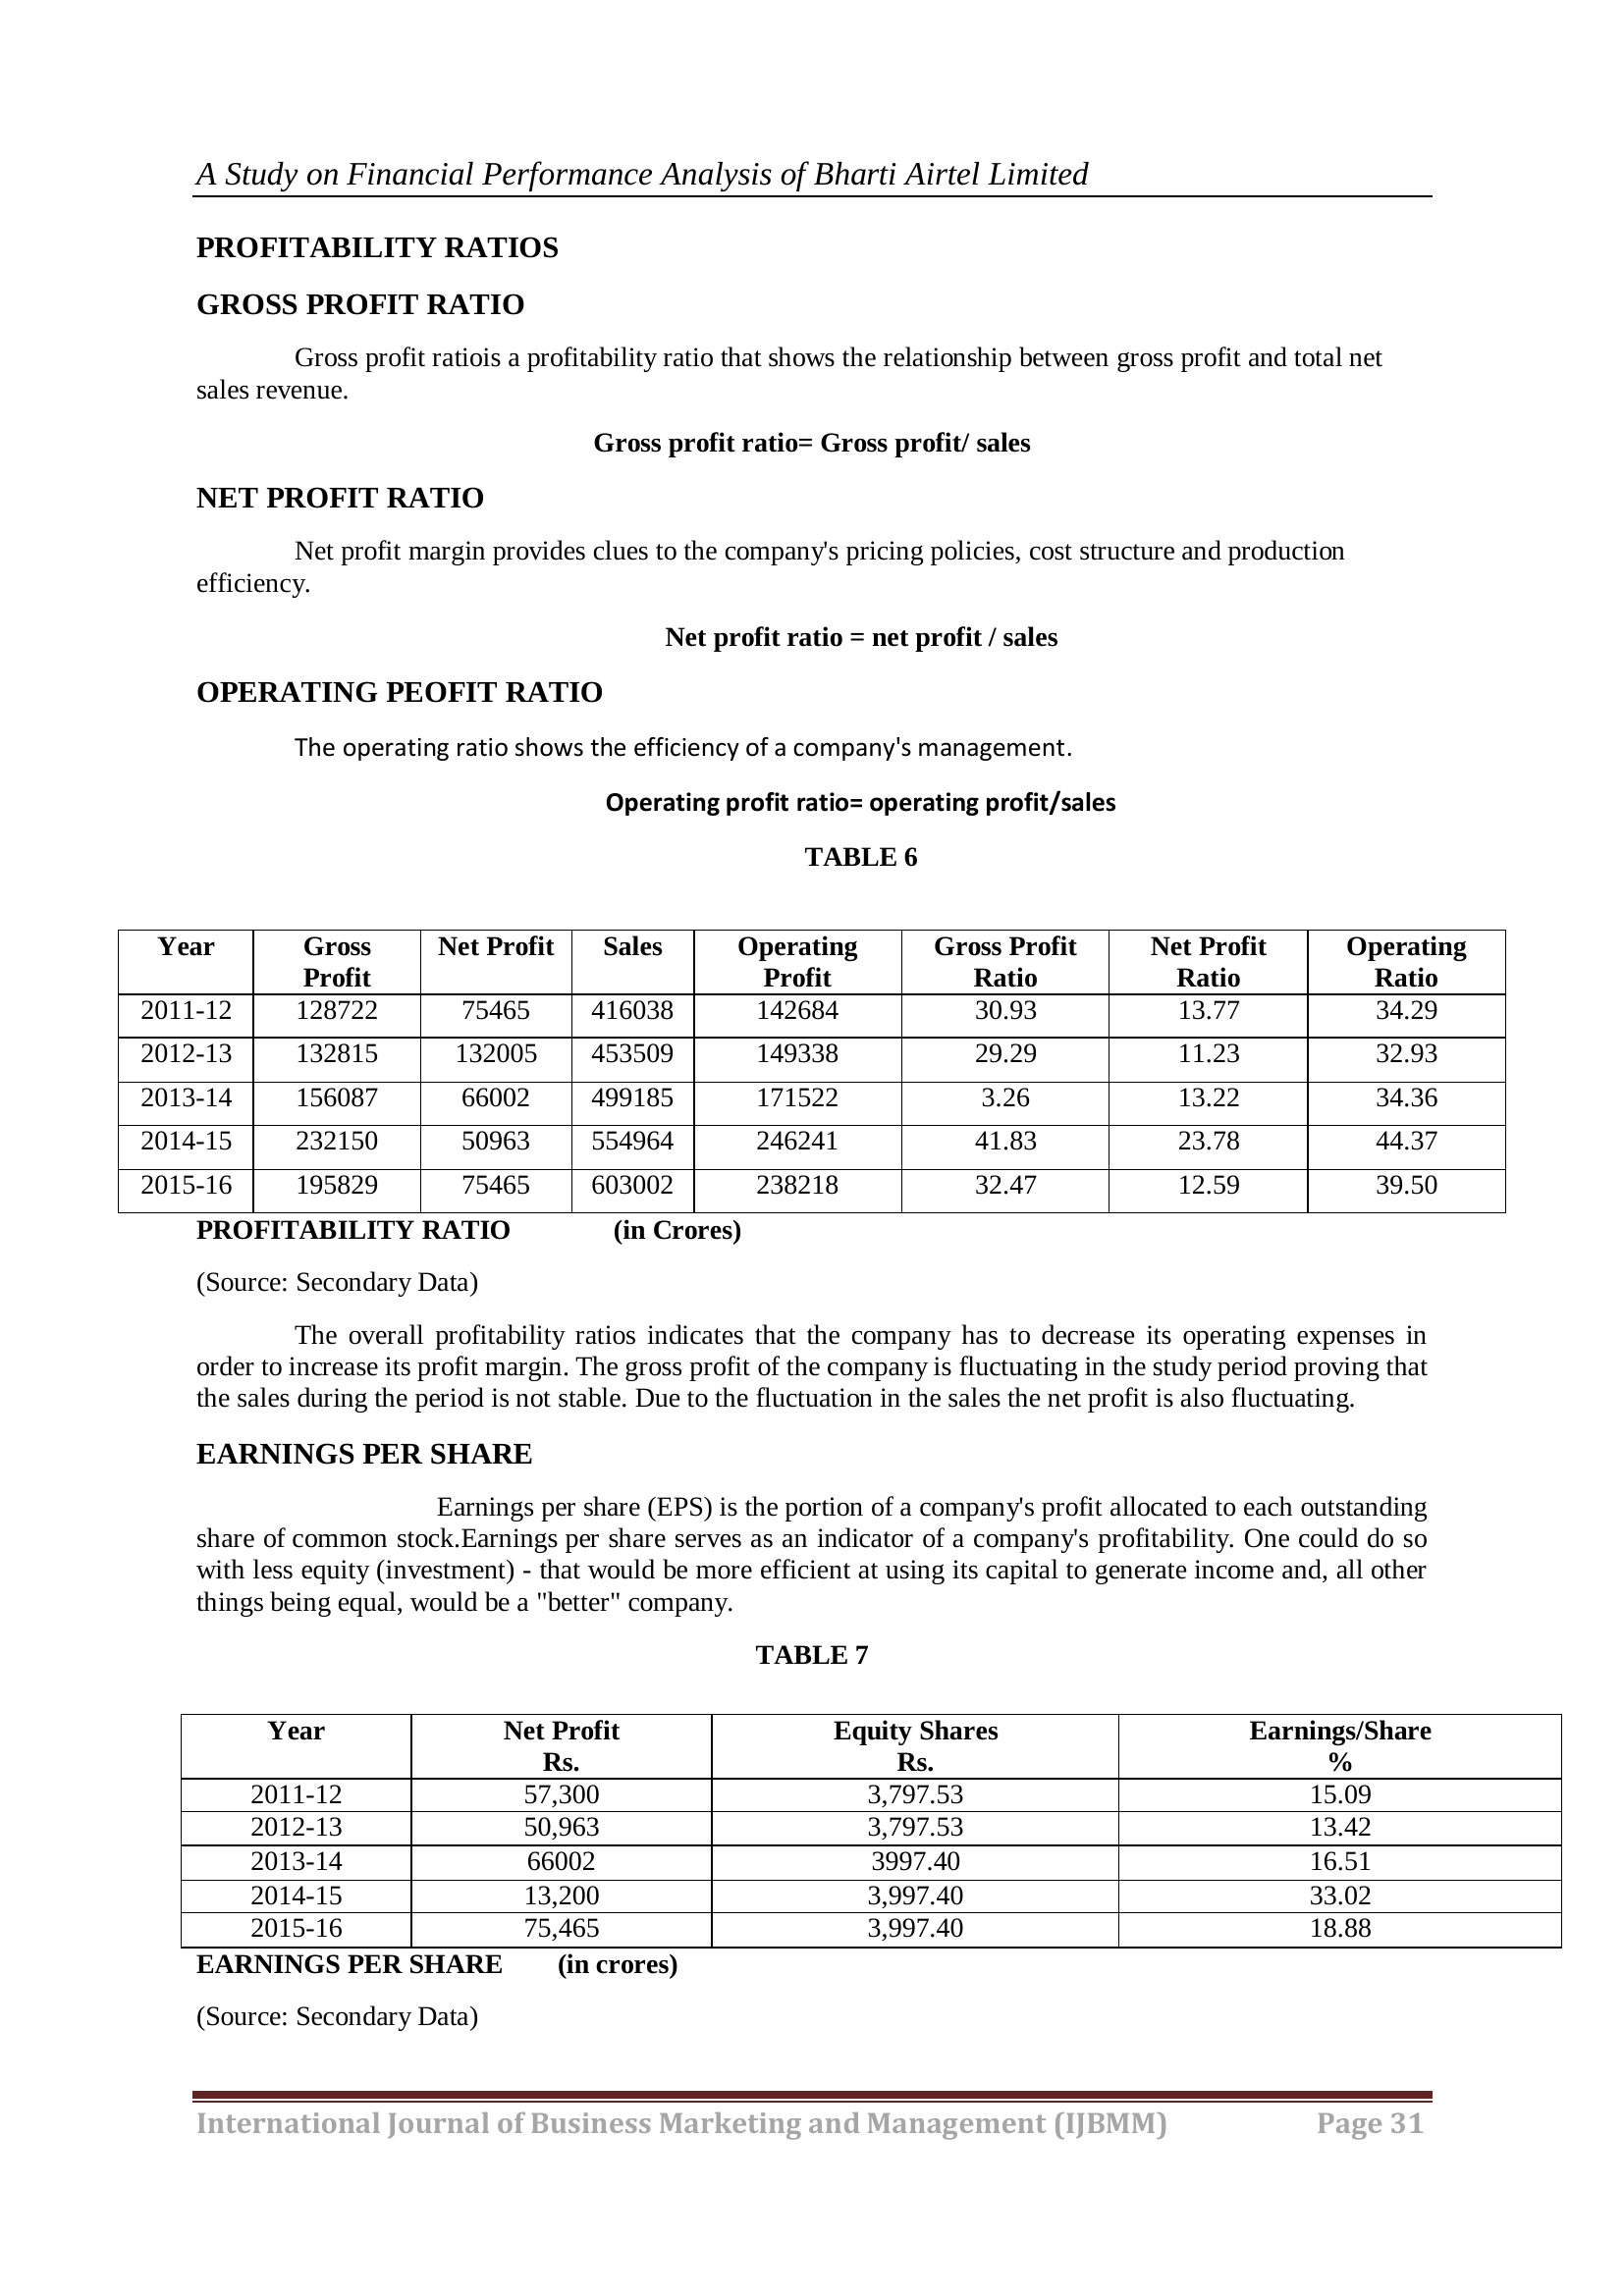

Document: /content/364253783.pdf, Page: 4 - Score: 19.7500


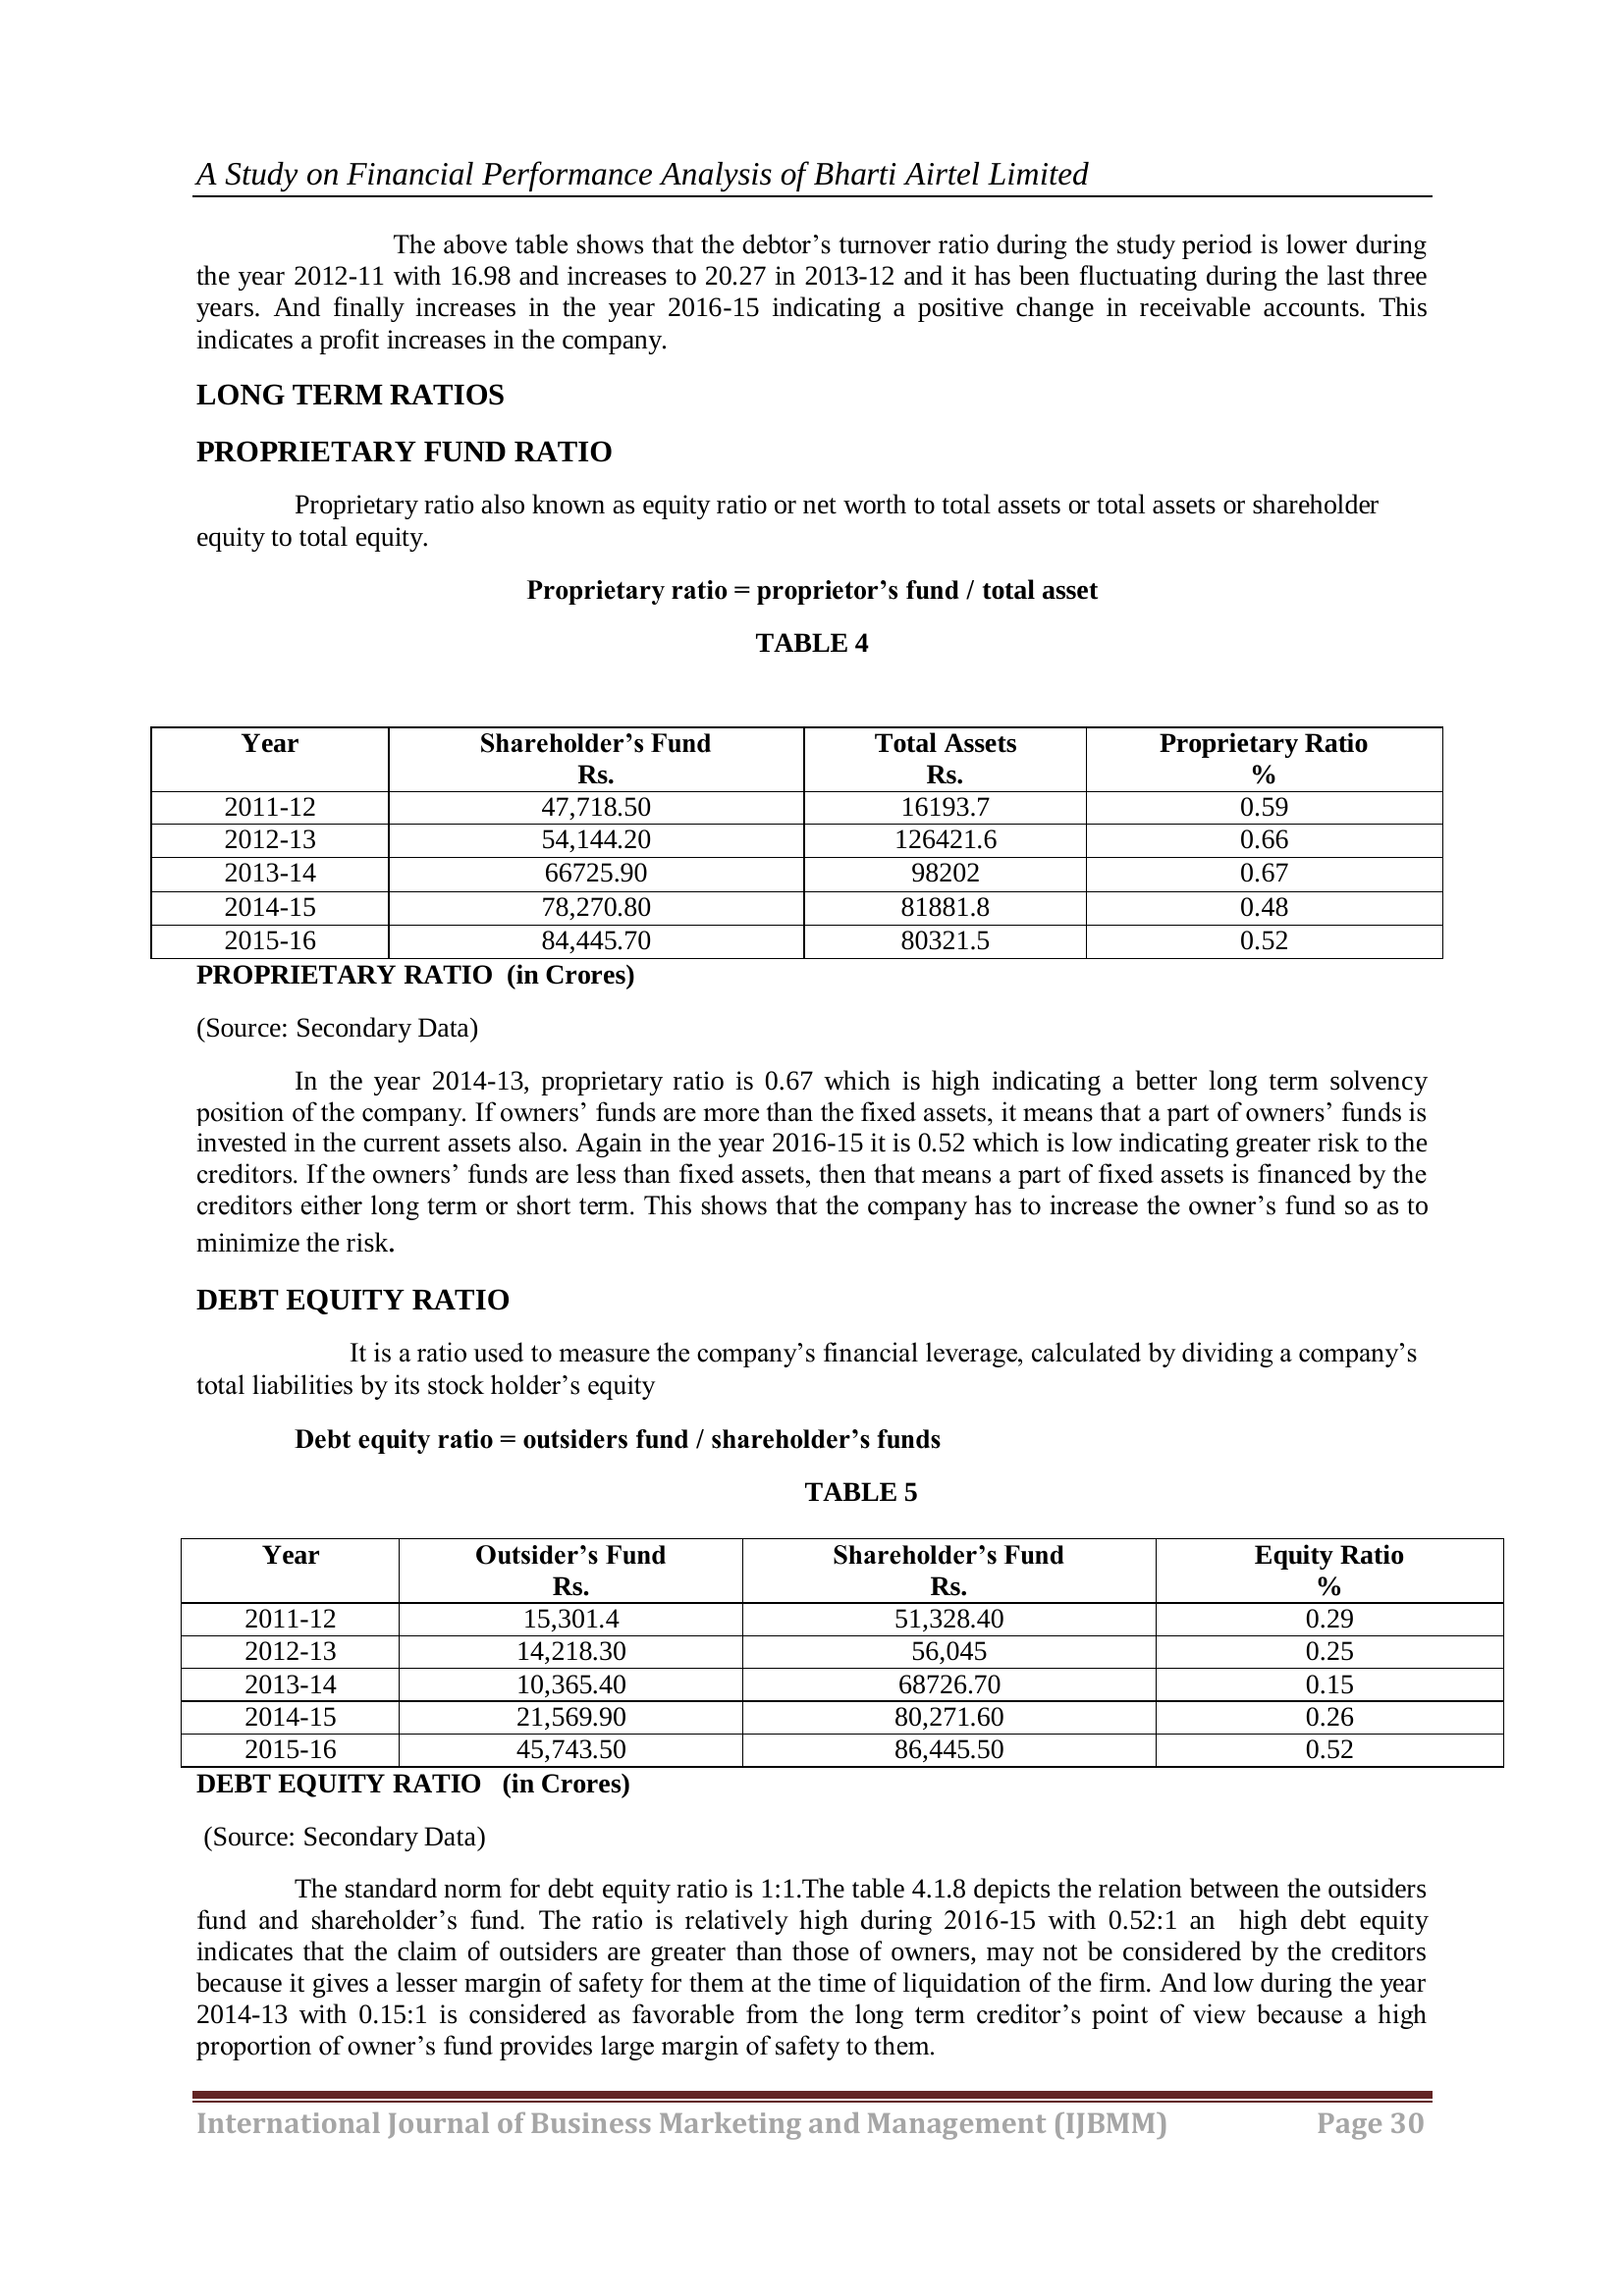


Query: FINDINGS?
Top 3 results:
Document: /content/364253783.pdf, Page: 1 - Score: 15.0625


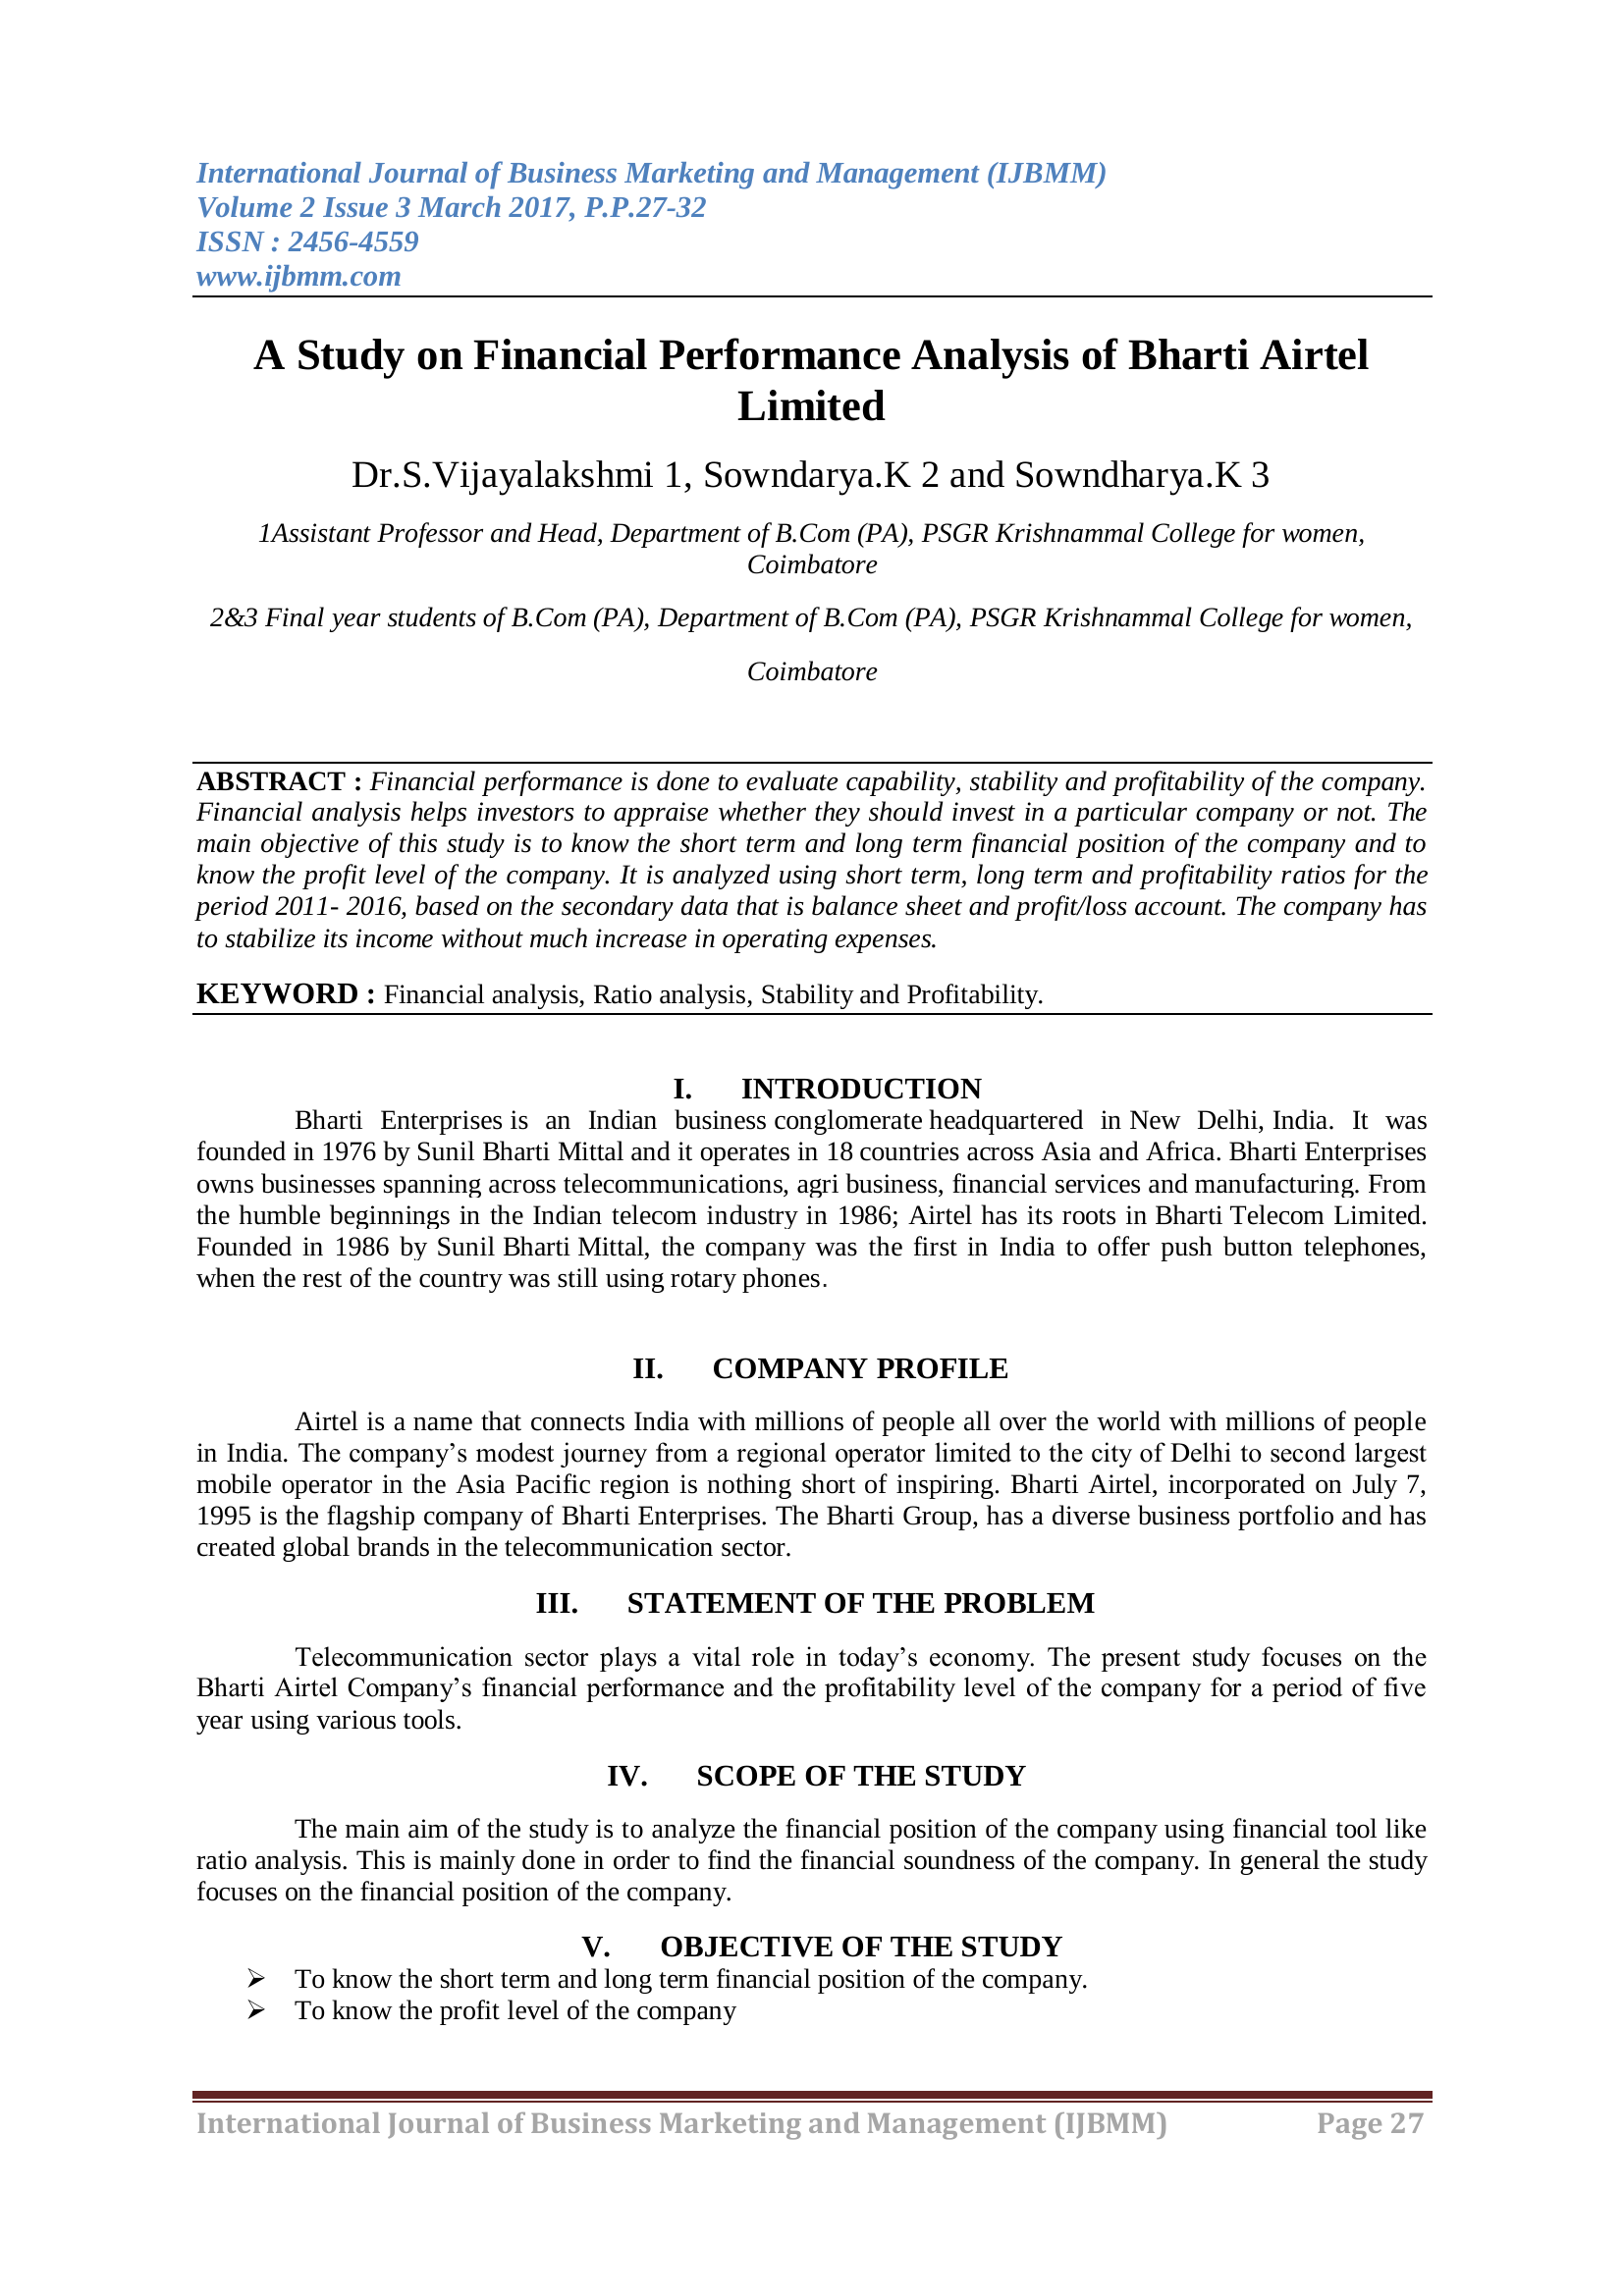

Document: /content/364253783.pdf, Page: 6 - Score: 15.0000


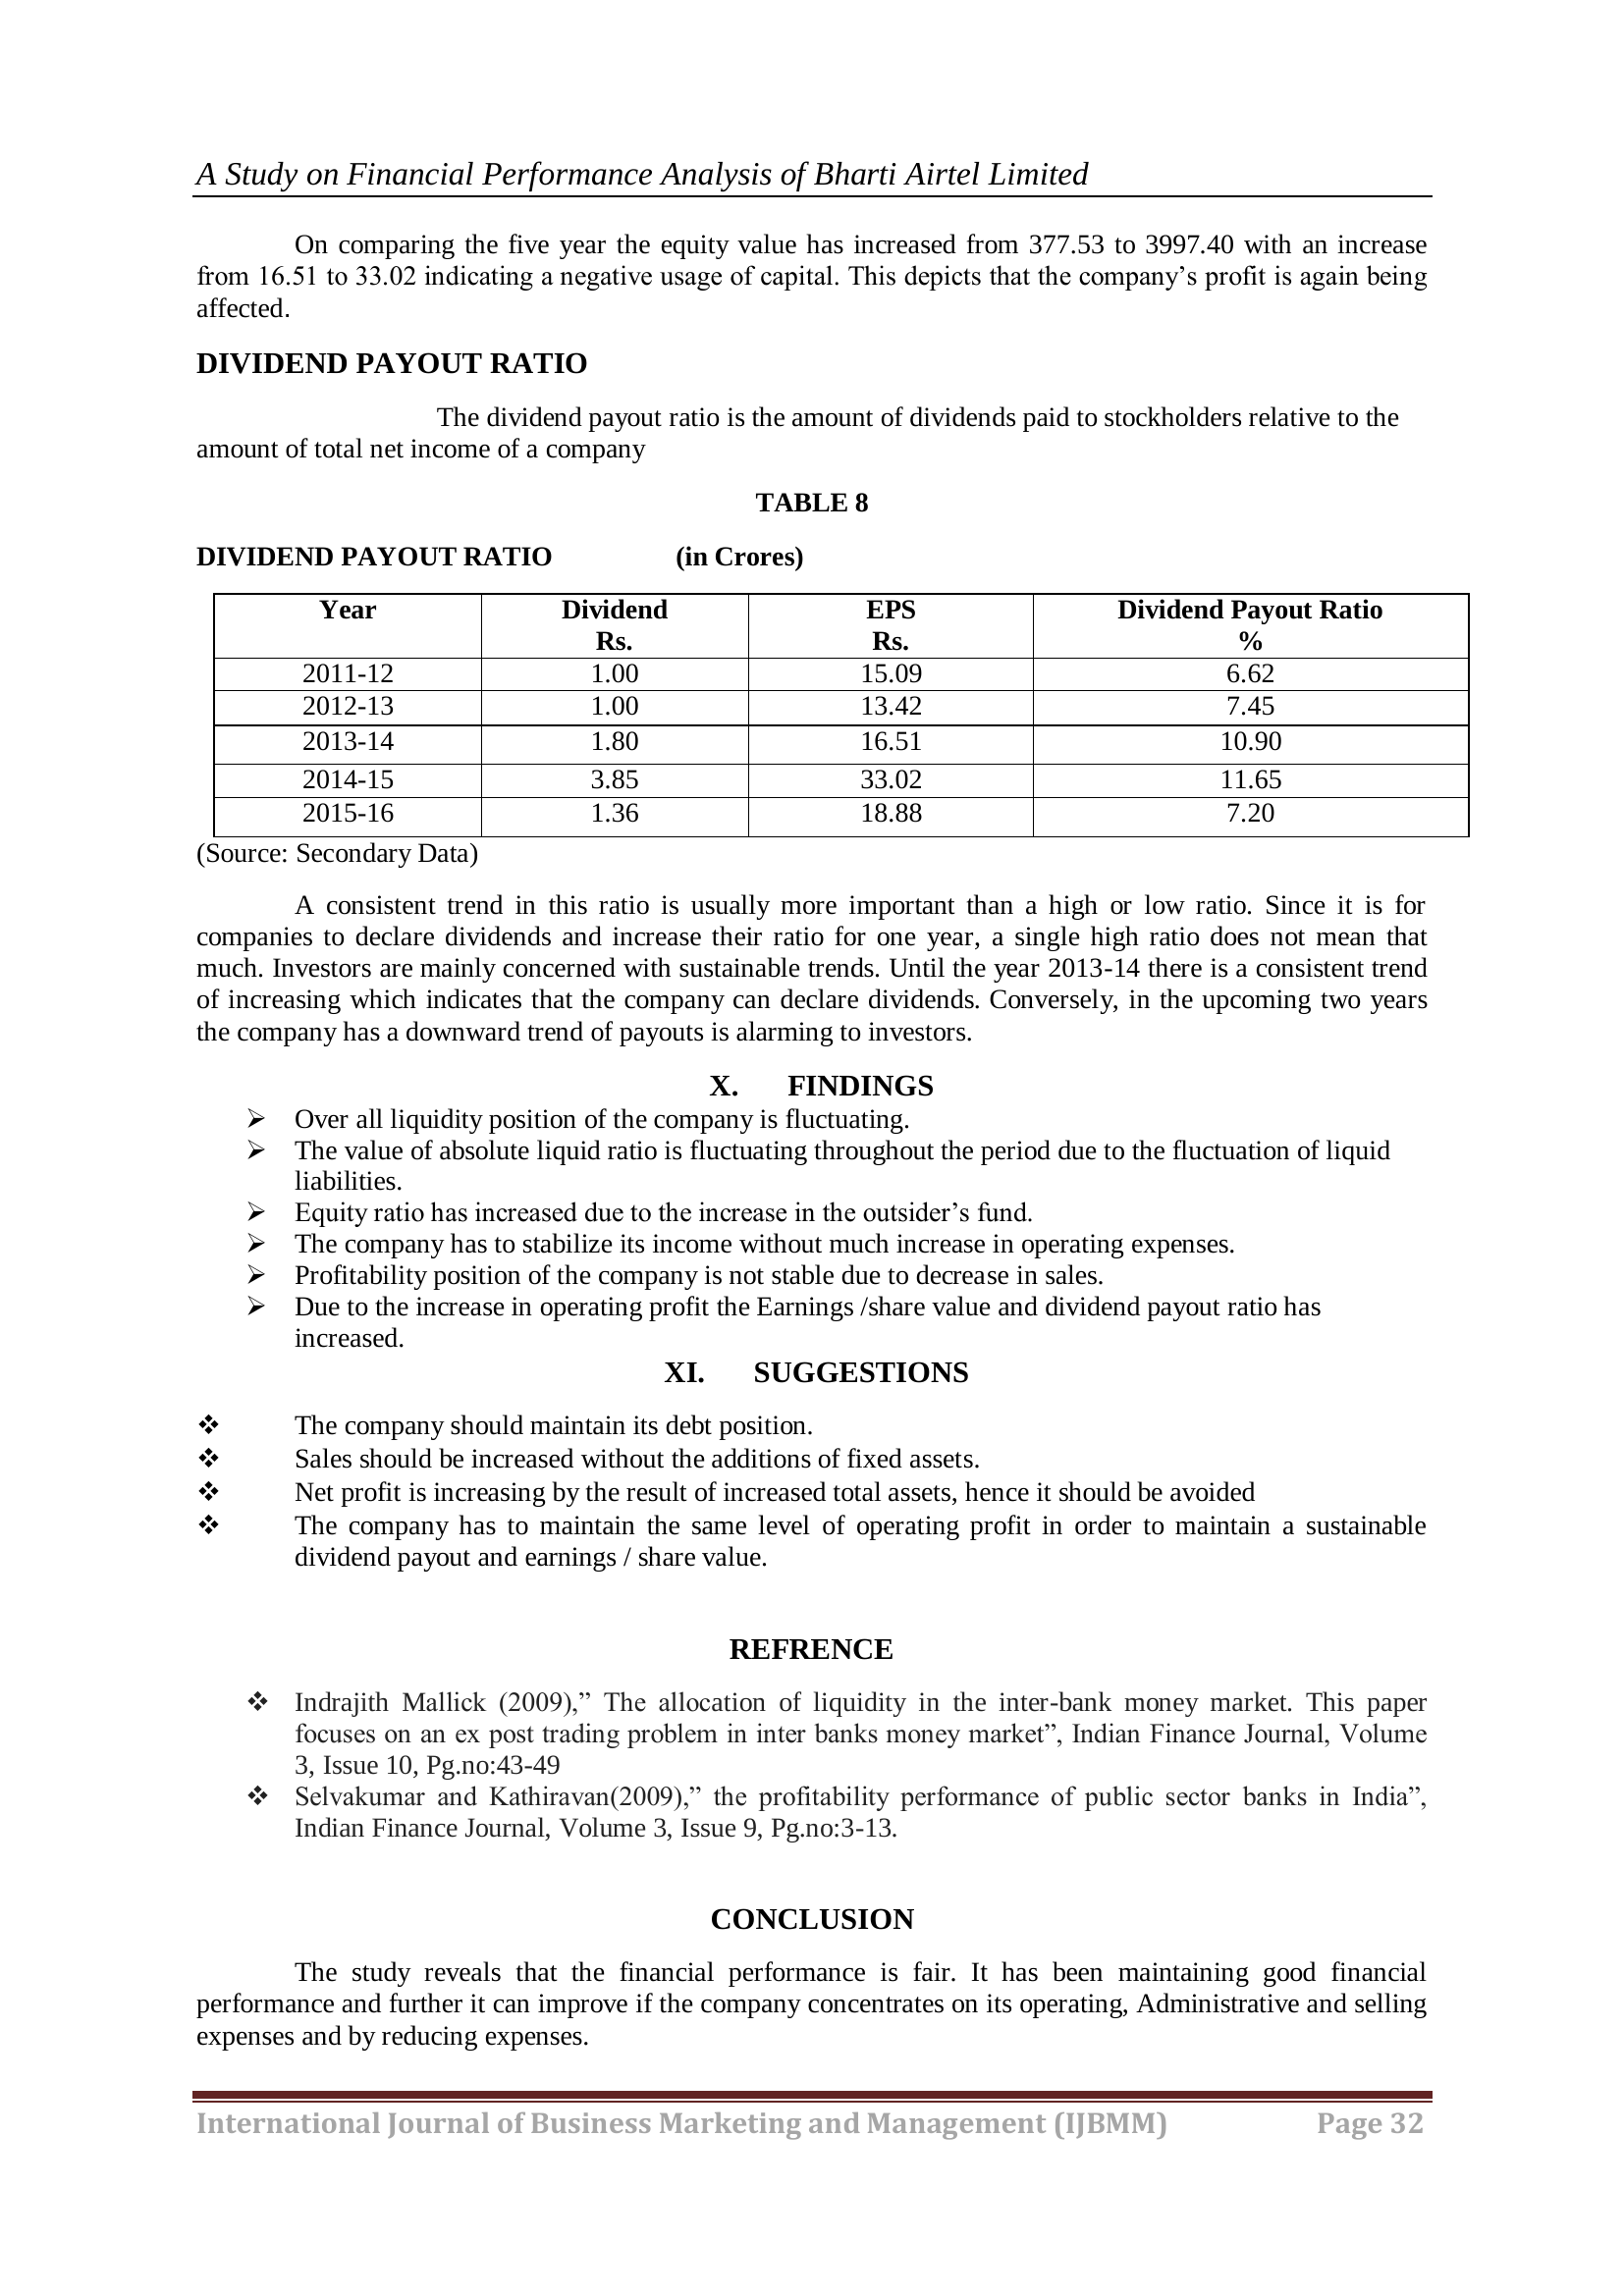

Document: /content/364253783.pdf, Page: 5 - Score: 15.0000


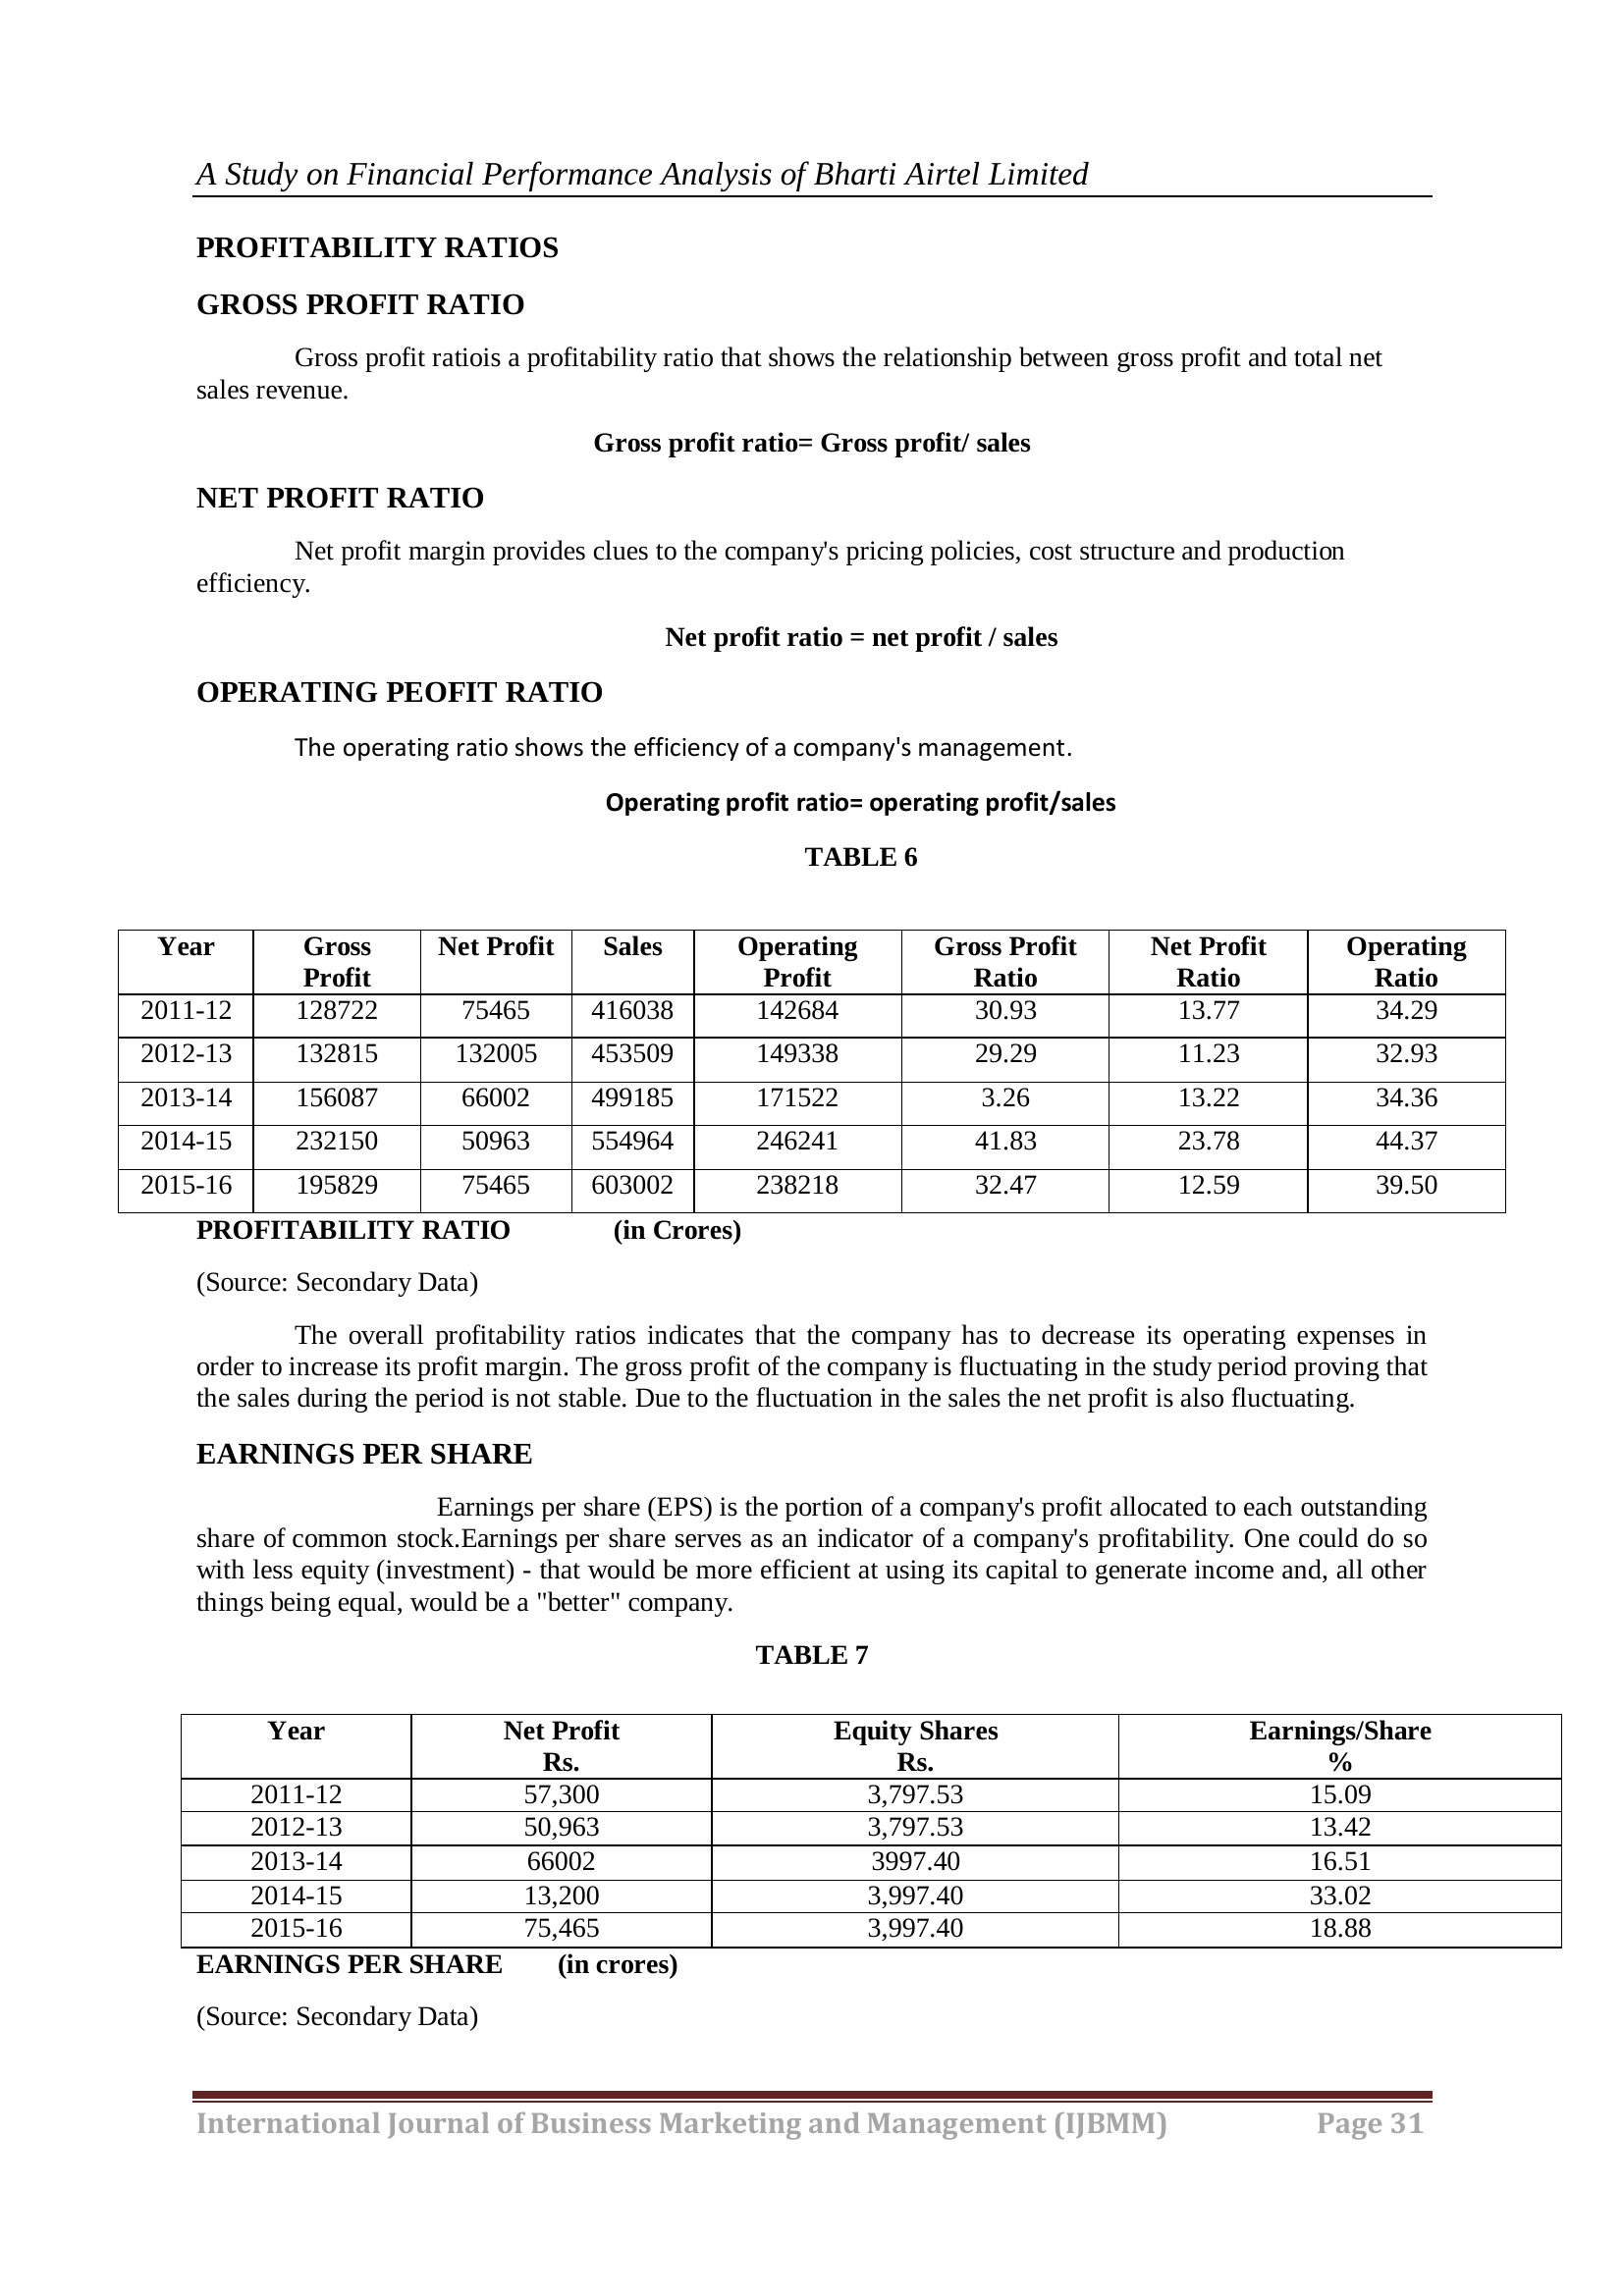

In [39]:
queries = ["Dr.S.Vijayalakshmi", "FINDINGS?"]

# Perform search and show document names with page information
search_documents(model, processor, documents_with_filenames, queries, top_k=3)

In [22]:
queries = ["Frozen Food","XYZ CONSULTING FIRM","Groceries","SOPHIE WRIGHT","Sally Branders"]

In [23]:
search_documents(model, processor, documents_with_filenames, queries, top_k=3)

100%|██████████| 1/1 [00:09<00:00,  9.67s/it]


tensor([1, 1, 0, 1, 1])
Top 1 Accuracy (verif): 0.2

Query: Frozen Food
Top 3 results:
Document: /content/sample_receipt.png - Score: 15.0625
Document: /content/job-resume-template-259-350x495.png - Score: 15.0
Document: /content/sample_bill.png - Score: 15.0

Query: XYZ CONSULTING FIRM
Top 3 results:
Document: /content/sample_receipt.png - Score: 17.0
Document: /content/job-resume-template-259-350x495.png - Score: 16.875
Document: /content/new-york-resume-templates.png - Score: 16.875

Query: Groceries
Top 3 results:
Document: /content/job-resume-template-259-350x495.png - Score: 14.875
Document: /content/new-york-resume-templates.png - Score: 14.875
Document: /content/sample_receipt.png - Score: 14.875

Query: SOPHIE WRIGHT
Top 3 results:
Document: /content/job-resume-template-259-350x495.png - Score: 16.75
Document: /content/sample_receipt.png - Score: 16.75
Document: /content/new-york-resume-templates.png - Score: 16.625

Query: Sally Branders
Top 3 results:
Document: /content/samp

#  Byaldi

In [40]:
!git clone https://github.com/AnswerDotAI/byaldi.git

Cloning into 'byaldi'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 148 (delta 74), reused 120 (delta 54), pack-reused 0 (from 0)
Receiving objects: 100% (148/148), 1.97 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
%cd byaldi

/content/byaldi


In [43]:
!pip install -e "."

Obtaining file:///content/byaldi
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 24.7 MB/s eta 0:00:00
  Building editable for Byaldi (pyproject.toml) ... done
  Created wheel for Byaldi: filename=Byaldi-0.0.2.post2-0.editable-py3-none-any.whl size=14046 sha256=825aca9e0dcce77026cc2095332d2d898cdc6426ac118e98dd5b710b583156a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_qiyc4x_/wheels/05/35/6c/7376a3a73ed94aa60fd0bd33179ccf86b026e0b8151ba8ba6e
Successfully built Byaldi
  Attempting uninstall: mteb
    Found existing installation: mteb 1.14.15
    Uninstalling mteb-1.14.15:
      Successfully uninstalled mteb-1.14.15


In [5]:
%cd byaldi

/content/byaldi/byaldi


In [7]:
from byaldi.byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [8]:
RAG.index(
    input_path="/content/364253783.pdf",
    index_name="image_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


{0: '/content/364253783.pdf'}

In [11]:
text_query = "Dr.S.Vijayalakshmi? "
results = RAG.search(text_query, k=3)
results

[{'doc_id': 0, 'page_num': 1, 'score': 19.75, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 2, 'score': 16.875, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 6, 'score': 15.125, 'metadata': {}, 'base64': None}]